# Intro to PyWarp

This notebook demonstrates how to compute a metric, evaluate its energy tensor, and visualise the result with `plotly`.

In [10]:
import os, sys, pathlib
root = pathlib.Path().resolve()
if not (root / 'warp').exists():
    root = root.parent
sys.path.insert(0, str(root))

from warp.core import alcubierre_metric
from warp.core import energy_tensor
from warp.metrics.get_alcubierre import metric_get_alcubierre
from warp.solver.get_energy_tensor import get_energy_tensor
import plotly.graph_objects as go
import numpy as np

## Building Metrics

The `warp.metrics` module provides helper functions for constructing spacetimes.
* `metric_get_minkowski` – build a Minkowski metric.
* `metric_get_alcubierre` – create an Alcubierre warp metric.
* `metric_get_alcubierre_comoving` – the comoving Alcubierre metric.

We'll use these helpers below to create example metrics.


In [11]:
from warp.metrics.get_minkowski import metric_get_minkowski
minkowski = metric_get_minkowski((2, 2, 2, 2))
minkowski['tensor'].shape

(4, 4, 2, 2, 2, 2)

In [12]:
velocities = [0.0, 0.1, 0.2]
metrics = [metric_get_alcubierre([3,4,4,4], [1,2,2,2], v, 1.0, 1.0, [1,1,1,1]) for v in velocities]
[m['params']['velocity'] for m in metrics]

[0.0, 0.1, 0.2]

In [13]:
# define grid and warp parameters
metric = alcubierre_metric(
    [3, 4, 4, 4],       # grid size (t, x, y, z)
    [1, 2, 2, 2],       # center of the warp bubble
    0.1,                # velocity fraction of c
    1.0,                # bubble radius
    1.0,                # bubble thickness
    [1, 1, 1, 1])       # scaling of coordinates
energy = energy_tensor(metric)

In [14]:
from warp.analyzer.eval_metric import eval_metric
analysis = eval_metric(metric, try_gpu=0, keep_positive=1, num_angular_vec=10, num_time_vec=5)
energy_conditions = analysis['null']

In [ ]:
# Extract the energy density (T_00 component) as a 4D array
energy_density = energy['tensor'][0, 0]
print(energy_density.shape)

In [ ]:
# Create coordinate grids for visualisation
t_idx = 0  # select time slice
z_idx = 0  # select z slice
slice2d = energy_density[t_idx, :, :, z_idx]
x = np.arange(slice2d.shape[0])
y = np.arange(slice2d.shape[1])
fig = go.Figure(data=go.Heatmap(x=x, y=y, z=slice2d))
fig.update_layout(title=f'Energy Density t={t_idx}, z={z_idx}', xaxis_title='x', yaxis_title='y')
fig.show()

## Visualizing Results

This section demonstrates how to generate momentum flow lines using `get_momentum_flow_lines` and how to plot kinematic scalars returned by `eval_metric`.

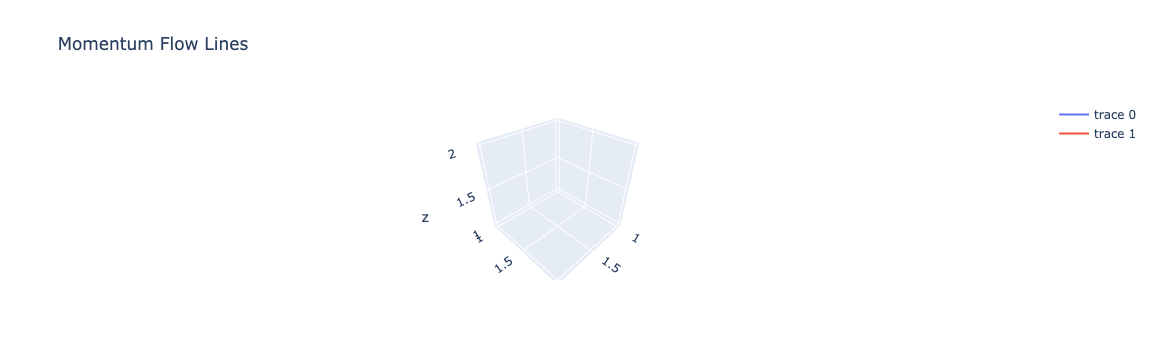

In [17]:
from warp.analyzer.get_momentum_flow_lines import get_momentum_flow_lines

# choose starting points in the spatial grid
start_points = [np.array([1, 2]), np.array([1, 2]), np.array([1, 2])]

tensor_slice = energy['tensor'][:, :, 1]
paths = get_momentum_flow_lines(
    tensor_slice,
    start_points,
    step_size=0.25,
    max_steps=50,
    scale_factor=0.1
)

fig = go.Figure()
for path in paths:
    fig.add_trace(go.Scatter3d(x=path[:,0], y=path[:,1], z=path[:,2], mode='lines'))
fig.update_layout(title='Momentum Flow Lines', scene=dict(xaxis_title='x', yaxis_title='y', zaxis_title='z'))
fig.show()

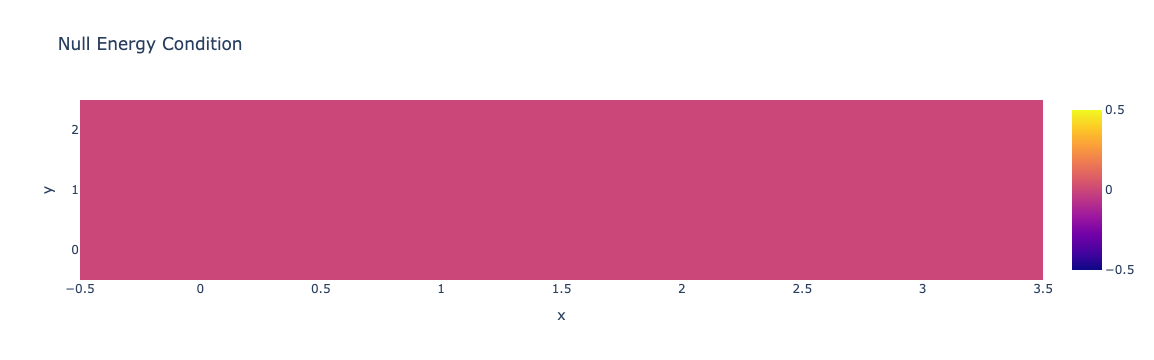

In [18]:
# Visualise the null energy condition
ec_slice = energy_conditions[0]
fig = go.Figure(data=go.Heatmap(z=ec_slice[1]))
fig.update_layout(title='Null Energy Condition', xaxis_title='x', yaxis_title='y')
fig.show()

## Parameter sweeps

The `run_parameter_sweep` helper evaluates `eval_metric` for each metric in an iterable and returns all the results as a list.

In [20]:
from warp.analyzer.eval_metric import eval_metric

results = eval_metric(metric)
expansion = results['expansion'][1]  # middle time slice
Y = X  # reuse grid for surface plot
fig = go.Figure(data=go.Surface(x=X, y=Y, z=expansion))
fig.update_layout(title='Expansion Scalar', scene=dict(xaxis_title='x', yaxis_title='y', zaxis_title='\theta'))
fig.show()

# shear and vorticity can be plotted similarly using results['shear'] and results['vorticity']

In [21]:
from warp.pipeline.simulation import run_parameter_sweep
from warp.metrics.get_minkowski import metric_get_minkowski

metrics = [metric_get_minkowski((2,2,2,2)) for _ in range(2)]
results = run_parameter_sweep(metrics)
print(len(results))

2


In [22]:
# Visualise momentum flow lines
from warp.analyzer.get_momentum_flow_lines import get_momentum_flow_lines
start = [np.array([0]), np.array([0]), np.array([0])]
paths = get_momentum_flow_lines(energy['tensor'][:, :, 1], start, 0.1, 50, 1.0, adaptive=True)
len(paths[0])

2